# B9DA108 Programming for Data Analysis (B9DA108_2223_TMD1S)

# Importing relevant libraries

In [1]:
import pandas as pd
import json
import requests
import sys


from pandas.io.json import json_normalize
from pymongo import MongoClient
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sqlalchemy import create_engine
from sqlalchemy import text


## Function to get Data
This might take some time due to large number of entries

In [2]:
#!pip install pymongo


In [3]:
def getDataFromApi():
    url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Police_Stop_Data/FeatureServer/0/query?where=OBJECTID%20%3E%3D%20150000%20AND%20OBJECTID%20%3C%3D%20160000&outFields=*&returnGeometry=false&outSR=4326&f=json'
#     url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Police_Stop_Data/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
    headers = {
        'Content-Type': "application/json",
        'cache-control': "no-cache"
        }
    response = requests.get(url, headers=headers)
    jsonData = response.json()
    print('Data fetched')
    return jsonData

PSD_data = getDataFromApi()

Data fetched


In [4]:
mongo_client = MongoClient("mongodb://localhost:27017") #connection created
mongo_client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [5]:
myDb = mongo_client["DAP"]#choosing database
print('new DB intialized')
mongo_client.list_database_names()

new DB intialized


['DAP', 'admin', 'config', 'local']

## Creating collections
Will take upto 3min 

In [6]:
PSD_raw_collection = myDb['PSD_unstruct_data']
#removing existing data in the collection, to avoid the chance of any duplicates while running code line by line
PSD_raw_collection.delete_many({})

for data in PSD_data['features']:
    row_data = data['attributes']
    PSD_raw_collection.insert_one(row_data)

#adding the metadata of the dataset to new collection for future reference
PSD_metadata = myDb['PSD_metadata']
PSD_metadata.delete_many({})
for data in PSD_data['fields']:
    PSD_metadata.insert_one(data)

## Getting data from MongoDB


In [7]:
#count of documents
print(PSD_raw_collection.count_documents({}))
#getting all documents into a pandas Dataframe
police_stop_data_mongo = PSD_raw_collection.find()
PSD_df =  pd.DataFrame(list(police_stop_data_mongo))
PSD_df.info()

10001
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   10001 non-null  object 
 1   OBJECTID              10001 non-null  int64  
 2   masterIncidentNumber  10001 non-null  object 
 3   responseDate          10001 non-null  int64  
 4   reason                9638 non-null   object 
 5   problem               10001 non-null  object 
 6   callDisposition       10001 non-null  object 
 7   citationIssued        9638 non-null   object 
 8   personSearch          9638 non-null   object 
 9   vehicleSearch         9638 non-null   object 
 10  preRace               9638 non-null   object 
 11  race                  9638 non-null   object 
 12  gender                9638 non-null   object 
 13  lat                   10001 non-null  float64
 14  long                  10001 non-null  float64
 15  x            

## Cleaning

In [8]:
# Removing Unwanted Columns like _id, x, y, lastUpdateDate
PSD_df_cleared = PSD_df.drop(columns=['_id', 'x', 'y', 'lastUpdateDate','masterIncidentNumber', 'preRace','callDisposition', 'neighborhood'])


#PSD_df_cleared = PSD_df_cleared.drop(columns=['_id', 'x', 'y', 'lastUpdateDate','masterIncidentNumber', 'preRace','callDisposition'])

#getting null value entities
null_df= PSD_df_cleared['race'].isnull()
none_data = PSD_df_cleared[null_df]
none_data.reset_index(inplace=True)
data_dict = none_data.to_dict("records")

#uploading nullvalue data to database for future reference
errorCollection = myDb['errorCollection']
for data in data_dict:
    errorCollection.insert_one(data)
    
#removing null value observations
PSD_droped_noneValues = PSD_df_cleared.dropna()

#removing Unknown and unwanted rows
PSD_removed_unknown = PSD_droped_noneValues[PSD_droped_noneValues.gender != ('Unknown')]
PSD_clean = PSD_removed_unknown[PSD_removed_unknown.race != 'Unknown']
PSD_clean = PSD_clean[PSD_clean.race != 'Unknown']
PSD_clean = PSD_clean[PSD_clean.gender != 'Gender Non-Conforming']
PSD_clean = PSD_clean[PSD_clean.reason != '']
PSD_clean = PSD_clean[PSD_clean.gender != '']
PSD_clean = PSD_clean[PSD_clean.citationIssued != '']

#after cleaning
PSD_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6865 entries, 0 to 10000
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID        6865 non-null   int64  
 1   responseDate    6865 non-null   int64  
 2   reason          6865 non-null   object 
 3   problem         6865 non-null   object 
 4   citationIssued  6865 non-null   object 
 5   personSearch    6865 non-null   object 
 6   vehicleSearch   6865 non-null   object 
 7   race            6865 non-null   object 
 8   gender          6865 non-null   object 
 9   lat             6865 non-null   float64
 10  long            6865 non-null   float64
 11  policePrecinct  6865 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 697.2+ KB


## Transformations


In [9]:

#changed the data type of policePrecinct
PSD_clean['policePrecinct'] = PSD_clean['policePrecinct'].astype(int)
#spliting date to day , month and year columns
PSD_clean['date'] = pd.to_datetime(PSD_clean['responseDate'],unit='ms')
PSD_clean['day'] = PSD_clean['date'].dt.strftime('%d')
PSD_clean['month'] = PSD_clean['date'].dt.strftime('%B')
PSD_clean['year'] = PSD_clean['date'].dt.strftime('%Y')


#Renaming problem values to short names
PSD_clean['problem'][PSD_clean['problem'] == 'Suspicious Person (P)'] = "Suspicious Person"
PSD_clean['problem'][PSD_clean['problem'] == 'Traffic Law Enforcement (P)'] = "Traffic Law Enforcement"
PSD_clean['problem'][PSD_clean['problem'] == 'Suspicious Vehicle (P)'] = "Suspicious Vehicle"
PSD_clean['problem'][PSD_clean['problem'] == 'Attempt Pick-Up (P)'] = "Attempt Pick-Up"
PSD_clean['problem'][PSD_clean['problem'] == 'Curfew Violations (P)'] = "Curfew Violations"
PSD_clean['problem'][PSD_clean['problem'] == 'Truancy (P)'] = "Truancy"

PSD_clean["problem"].unique()


C:\Users\joseg\AppData\Local\Temp\ipykernel_18932\3912815662.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PSD_clean['problem'][PSD_clean['problem'] == 'Suspicious Person (P)'] = "Suspicious Person"
C:\Users\joseg\AppData\Local\Temp\ipykernel_18932\3912815662.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PSD_clean['problem'][PSD_clean['problem'] == 'Traffic Law Enforcement (P)'] = "Traffic Law Enforcement"
C:\Users\joseg\AppData\Local\Temp\ipykernel_18932\3912815662.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

array(['Traffic Law Enforcement', 'Suspicious Person',
       'Suspicious Vehicle', 'Attempt Pick-Up'], dtype=object)

In [10]:
PSD_clean

,OBJECTID,responseDate,reason,problem,citationIssued,personSearch,vehicleSearch,race,gender,lat,long,policePrecinct,date,day,month,year
0,150000,1582026965000,Equipment Violation,Traffic Law Enforcement,YES,YES,YES,Black,Male,45.003870,-93.308200,4,2020-02-18 11:56:05,18,February,2020
1,150001,1582027434000,Moving Violation,Traffic Law Enforcement,NO,NO,NO,Black,Male,45.012332,-93.306970,4,2020-02-18 12:03:54,18,February,2020
3,150003,1582030517000,Moving Violation,Traffic Law Enforcement,YES,YES,YES,Black,Male,45.001490,-93.289520,4,2020-02-18 12:55:17,18,February,2020
6,150006,1582035418000,Moving Violation,Traffic Law Enforcement,NO,NO,NO,White,Male,45.019486,-93.298100,4,2020-02-18 14:16:58,18,February,2020
7,150007,1582035454000,Investigative,Traffic Law Enforcement,NO,YES,YES,Black,Male,45.023960,-93.291850,4,2020-02-18 14:17:34,18,February,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,159995,1590353610000,Moving Violation,Traffic Law Enforcement,YES,NO,NO,Black,Female,44.982621,-93.281221,1,2020-05-24 20:53:30,24,May,2020
9996,159996,1590354184000,Moving Violation,Traffic Law Enforcement,YES,NO,NO,Black,Female,44.982621,-93.281221,1,2020-05-24 21:03:04,24,May,2020
9998,159998,1590356386000,Moving Violation,Traffic Law Enforcement,NO,YES,YES,Black,Female,44.989685,-93.286732,1,2020-05-24 21:39:46,24,May,2020
9999,159999,1590359300000,Investigative,Suspicious Vehicle,YES,YES,YES,Black,Male,45.013210,-93.303180,4,2020-05-24 22:28:20,24,May,2020


# Incidens Noticed for Moving Violation

In [11]:
PSD_clean.loc[PSD_clean['reason'] == "Moving Violation"]


,OBJECTID,responseDate,reason,problem,citationIssued,personSearch,vehicleSearch,race,gender,lat,long,policePrecinct,date,day,month,year
1,150001,1582027434000,Moving Violation,Traffic Law Enforcement,NO,NO,NO,Black,Male,45.012332,-93.306970,4,2020-02-18 12:03:54,18,February,2020
3,150003,1582030517000,Moving Violation,Traffic Law Enforcement,YES,YES,YES,Black,Male,45.001490,-93.289520,4,2020-02-18 12:55:17,18,February,2020
6,150006,1582035418000,Moving Violation,Traffic Law Enforcement,NO,NO,NO,White,Male,45.019486,-93.298100,4,2020-02-18 14:16:58,18,February,2020
19,150019,1582053879000,Moving Violation,Traffic Law Enforcement,NO,NO,NO,Black,Male,44.981220,-93.274800,1,2020-02-18 19:24:39,18,February,2020
23,150023,1582055158000,Moving Violation,Traffic Law Enforcement,NO,NO,NO,Black,Female,44.984280,-93.308300,4,2020-02-18 19:45:58,18,February,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,159993,1590352690000,Moving Violation,Traffic Law Enforcement,YES,NO,NO,East African,Male,44.982621,-93.281221,1,2020-05-24 20:38:10,24,May,2020
9995,159995,1590353610000,Moving Violation,Traffic Law Enforcement,YES,NO,NO,Black,Female,44.982621,-93.281221,1,2020-05-24 20:53:30,24,May,2020
9996,159996,1590354184000,Moving Violation,Traffic Law Enforcement,YES,NO,NO,Black,Female,44.982621,-93.281221,1,2020-05-24 21:03:04,24,May,2020
9998,159998,1590356386000,Moving Violation,Traffic Law Enforcement,NO,YES,YES,Black,Female,44.989685,-93.286732,1,2020-05-24 21:39:46,24,May,2020


# Visualizations

(44.89233672, 45.05113)

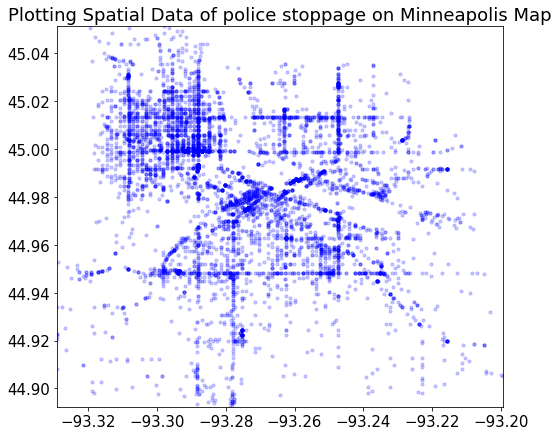

In [28]:
#spatial plot showing the stoppage event over the Minnneapolis map

BBox = (PSD_clean.long.min(),   PSD_clean.long.max(),PSD_clean.lat.min(), PSD_clean.lat.max())




fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(PSD_clean.long, PSD_clean.lat, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data of police stoppage on Minneapolis Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])





(44.89233672, 45.05113)

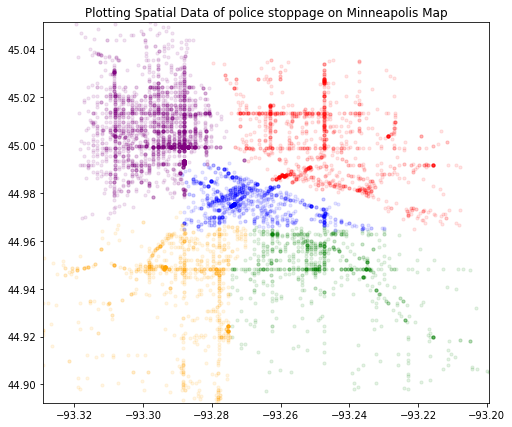

In [19]:
## spatial map by different Police Precincts

#creating subset of dataset on the basis of policePrecinct
PSD_clean_pr1 = PSD_clean.loc[PSD_clean['policePrecinct'] == 1]
PSD_clean_pr2 = PSD_clean.loc[PSD_clean['policePrecinct'] == 2]
PSD_clean_pr3 = PSD_clean.loc[PSD_clean['policePrecinct'] == 3]
PSD_clean_pr4 = PSD_clean.loc[PSD_clean['policePrecinct'] == 4]
PSD_clean_pr5 = PSD_clean.loc[PSD_clean['policePrecinct'] == 5]

BBox = (PSD_clean.long.min(),   PSD_clean.long.max(),PSD_clean.lat.min(), PSD_clean.lat.max())



fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(PSD_clean_pr1.long, PSD_clean_pr1.lat, zorder=1, alpha= 0.1, c='blue', s=10) #plotting all precinct 1 events
ax.scatter(PSD_clean_pr2.long, PSD_clean_pr2.lat, zorder=1, alpha= 0.1, c='red', s=10) #plotting all precinct 2 events
ax.scatter(PSD_clean_pr3.long, PSD_clean_pr3.lat, zorder=1, alpha= 0.1, c='green', s=10) #plotting all precinct 3 events
ax.scatter(PSD_clean_pr4.long, PSD_clean_pr4.lat, zorder=1, alpha= 0.1, c='purple', s=10) #plotting all precinct 4 events
ax.scatter(PSD_clean_pr5.long, PSD_clean_pr5.lat, zorder=1, alpha= 0.1, c='orange', s=10) #plotting all precinct 5 events
ax.set_title('Plotting Spatial Data of police stoppage on Minneapolis Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])


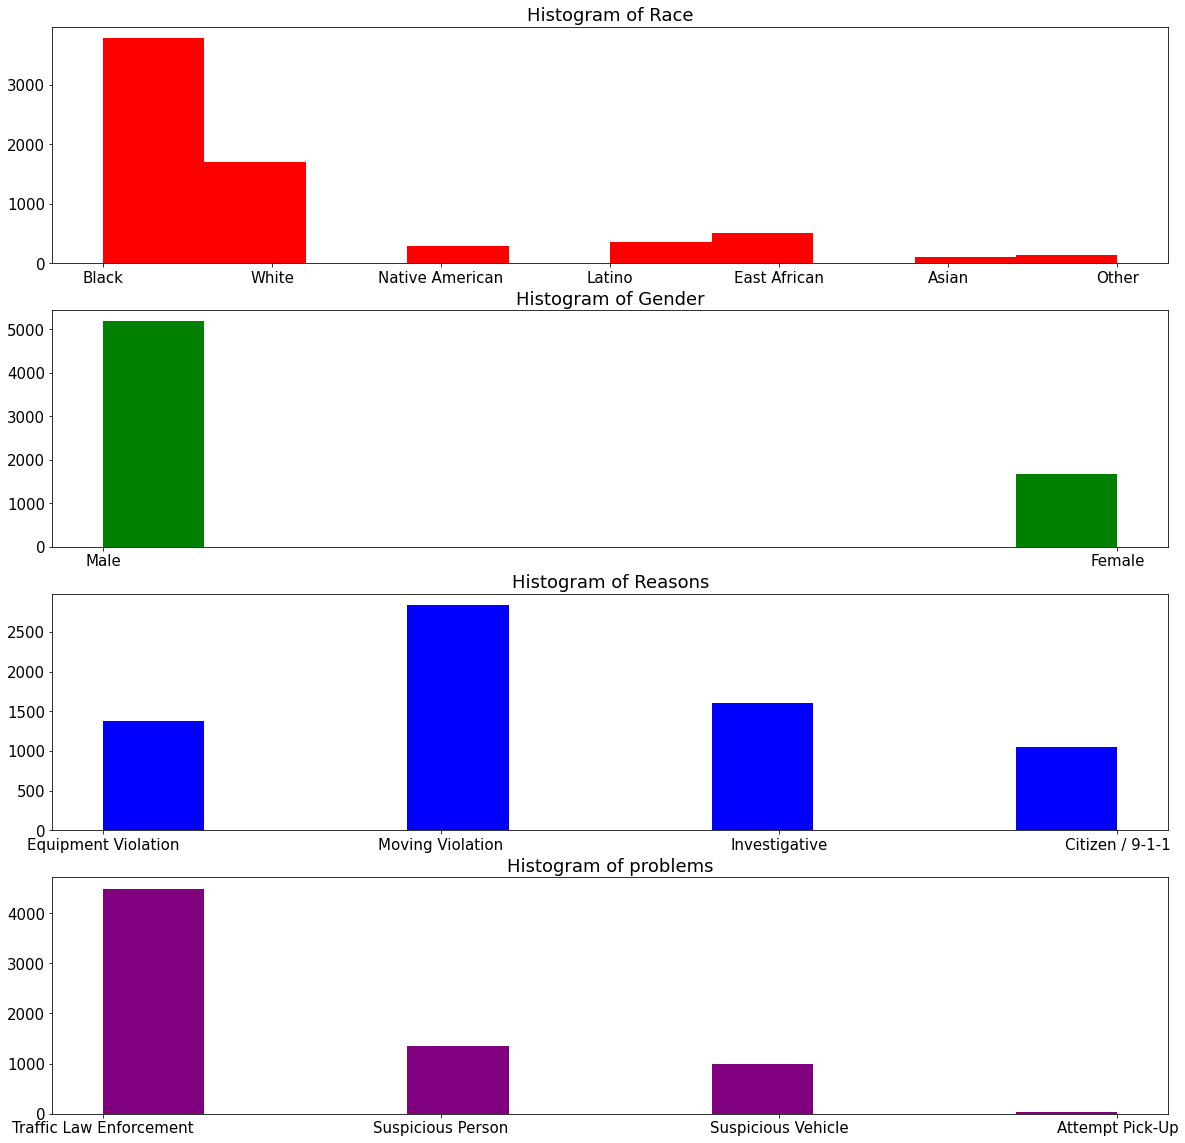

In [29]:

plt.rcParams.update({'font.size': 15})

fig, [ax, ax1, ax2, ax3] = plt.subplots(4,1,figsize=(20,20))

ax.hist(PSD_clean["race"], color="red")
ax.set_title('Histogram of Race')

ax1.hist(PSD_clean["gender"], color="green")
ax1.set_title('Histogram of Gender')# f, ax = plt.subplots(figsize=(12, 6))

ax2.hist(PSD_clean["reason"], color="blue")
ax2.set_title('Histogram of Reasons')

ax3.hist(PSD_clean["problem"], color="purple")
ax3.set_title('Histogram of problems')

ax3.figure.savefig('hist.png')

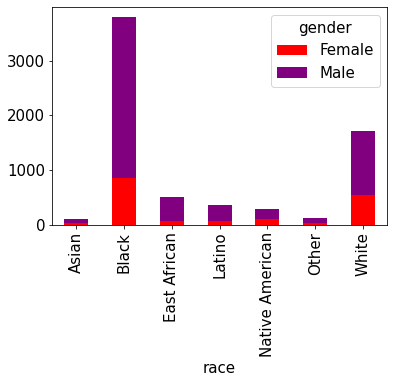

In [30]:
#grouping the dataset on the basis of race and gender and saved into another dataframe
PSD_clean_stack = PSD_clean.groupby(['race', 'gender']).size().reset_index().pivot(columns='gender', index='race', values=0)
#creating the bar chart
ax = PSD_clean_stack.plot(kind='bar', stacked=True,color = ['r','purple'])
ax.figure.savefig('race_gender_stack.png')

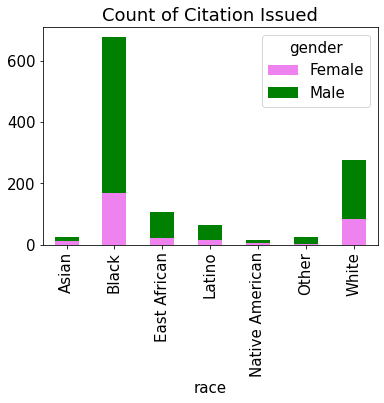

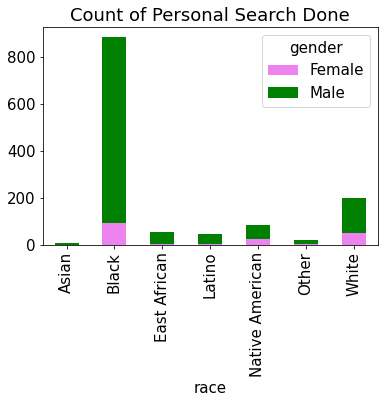

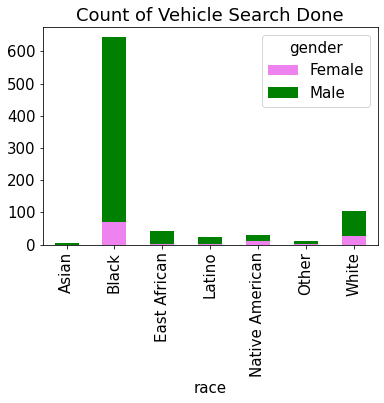

In [31]:

PSD_clean_citationIssued = PSD_clean.loc[PSD_clean['citationIssued'] == 'YES']
PSD_clean_personSearch = PSD_clean.loc[PSD_clean['personSearch'] == 'YES']
PSD_clean_vehicleSearch = PSD_clean.loc[PSD_clean['vehicleSearch'] == 'YES']

PSD_clean_citationIssued_stack = PSD_clean_citationIssued.groupby(['race', 'gender']).size().reset_index().pivot(columns='gender', index='race', values=0)
ax1 = PSD_clean_citationIssued_stack.plot(kind='bar', stacked=True,color = ['violet','g'])
ax1.title.set_text('Count of Citation Issued')
ax1.figure.savefig('citation_race_gender_stack.png')

PSD_clean_personSearch_stack = PSD_clean_personSearch.groupby(['race', 'gender']).size().reset_index().pivot(columns='gender', index='race', values=0)
ax2 = PSD_clean_personSearch_stack.plot(kind='bar', stacked=True,color = ['violet','g'])
ax2.title.set_text('Count of Personal Search Done')
ax2.figure.savefig('personSearch_race_gender_stack.png')

PSD_clean_vehicleSearch_stack = PSD_clean_vehicleSearch.groupby(['race', 'gender']).size().reset_index().pivot(columns='gender', index='race', values=0)
ax3 = PSD_clean_vehicleSearch_stack.plot(kind='bar', stacked=True,color = ['violet','g'])
ax3.title.set_text('Count of Vehicle Search Done')
ax3.figure.savefig('vehicleSearch_race_gender_stack.png')

In [ ]:
From the studies its clear that Black community is more involved in the police actions. Over 50% incidents are related to Black and African people.  

In [32]:

PSD_clean_blacksonly = PSD_clean.loc[PSD_clean['race'] != 'Black'] #removed 2021 since it is not completed
PSD_clean_blacksonly


,OBJECTID,responseDate,reason,problem,citationIssued,personSearch,vehicleSearch,race,gender,lat,long,policePrecinct,date,day,month,year
6,150006,1582035418000,Moving Violation,Traffic Law Enforcement,NO,NO,NO,White,Male,45.019486,-93.298100,4,2020-02-18 14:16:58,18,February,2020
10,150010,1582038222000,Investigative,Traffic Law Enforcement,NO,NO,NO,White,Male,44.968423,-93.259677,1,2020-02-18 15:03:42,18,February,2020
24,150024,1582058060000,Investigative,Suspicious Person,NO,YES,NO,Native American,Male,44.999138,-93.288756,4,2020-02-18 20:34:20,18,February,2020
30,150030,1582062522000,Equipment Violation,Traffic Law Enforcement,NO,NO,NO,Latino,Male,44.948362,-93.292554,5,2020-02-18 21:48:42,18,February,2020
31,150031,1582062541000,Citizen / 9-1-1,Suspicious Person,NO,NO,NO,White,Male,44.982643,-93.244437,2,2020-02-18 21:49:01,18,February,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,159990,1590348036000,Investigative,Suspicious Person,NO,NO,NO,White,Male,45.006853,-93.226898,2,2020-05-24 19:20:36,24,May,2020
9991,159991,1590348677000,Moving Violation,Traffic Law Enforcement,NO,NO,NO,East African,Male,45.003075,-93.255637,2,2020-05-24 19:31:17,24,May,2020
9992,159992,1590348699000,Equipment Violation,Traffic Law Enforcement,NO,NO,NO,White,Male,44.991350,-93.228210,2,2020-05-24 19:31:39,24,May,2020
9993,159993,1590352690000,Moving Violation,Traffic Law Enforcement,YES,NO,NO,East African,Male,44.982621,-93.281221,1,2020-05-24 20:38:10,24,May,2020
